In [592]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#pip install plotly==4.9.0
import plotly

import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [593]:
titanic_train_data=pd.read_csv('train.csv')
titanic_train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


### Data Cleaning

In [594]:
titanic_train_data[0:].isna().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Since I do not have a clear representation of cabin numbers for all 891 rows, I deem it unnecessary to keep the column. Furthermore, I believe we can use pclass to see the effect the sunken ship had on the passengers on board. I think it is fair to assume that passengers with pclass 1 had more lucrative cabins than those passengers with pclass 3. NOTE: Passengers with Pclass 1 had to pay more for their spot than those with pclass 3. 

Adding on, since our goal is to determine the likelihood of someone surving, we can discard Name, Embarked, and Ticket ID. We can delete passengerId as we are not asked any specifics of anyone on board the Titanic.

In [595]:
#check for nulls and data types

titanic_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [596]:
# set null values in age column to the average age. This helps us to use all our data for our classification models.
titanic_train_data['Age'] = titanic_train_data['Age'].replace(np.nan,titanic_train_data.Age.median())


In [597]:
# drop Cabin, PassengerId, Name, ticket, and Embarked columns.
titanic_train_data= titanic_train_data.drop(['Cabin','PassengerId','Name','Ticket','Embarked'],axis=1)


In [598]:
titanic_train_data.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


### Data Analysis

In [599]:
#color scheme

COLOR_MAP = {0 : 'red',
            1 : 'green',
            2 : 'blue',
            3 : 'yellow',
            4 : 'black',
            5 : '#25a186ff',
            6 : '#35b479ff',
            7 : '#5cc863ff',
            8 : '#c3df2eff',
            9 : '#fde725ff'
           }

Let's take a closer look at how many people were on board for each class and gender.

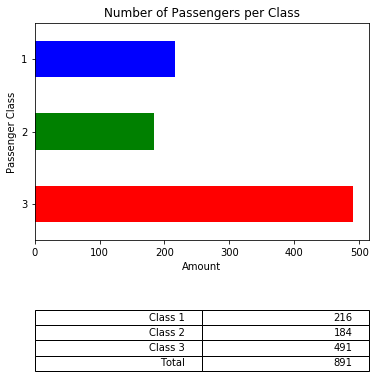

In [600]:
pclass_values=titanic_train_data['Pclass'].value_counts().sort_index(ascending=False)
pclass_values_table=[['Class 1',len(titanic_train_data[titanic_train_data['Pclass']==1])],['Class 2',len(titanic_train_data[titanic_train_data['Pclass']==2])]
                     , ['Class 3', len(titanic_train_data[titanic_train_data['Pclass']==3])],['Total',len(titanic_train_data['Pclass'])]]
color1 = [COLOR_MAP[l] for l in range(len(pclass_values))]
pclass_values.plot('barh',color=color1)
plt.xlabel('Amount')
plt.ylabel('Passenger Class')
plt.title('Number of Passengers per Class')
plt.table(cellText=pclass_values_table,bbox=[0.0,-0.6,1,0.28])


#### Age Distribution

Let's take a closer look at the age distribution aboard the Titanic. I'll examine the age distribution of each passenger class.

Text(0.5, 1.0, 'Age Distribution')

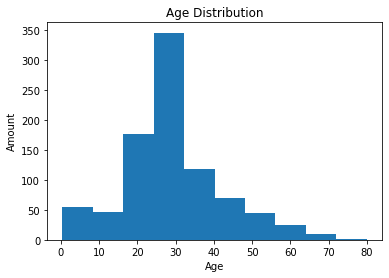

In [601]:
plt.hist(titanic_train_data['Age'])
plt.xlabel('Age')
plt.ylabel('Amount')
plt.title('Age Distribution')

Text(0.5, 1.0, 'Age Distribution in  Class 1')

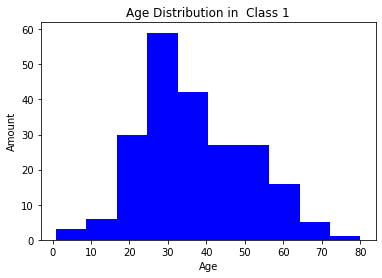

In [602]:
p1=titanic_train_data[titanic_train_data['Pclass']==1]
plt.hist( p1['Age'],color='blue')
plt.xlabel('Age')
plt.ylabel('Amount')
plt.title('Age Distribution in  Class 1')


Text(0.5, 1.0, 'Age Distribution in  Class 2')

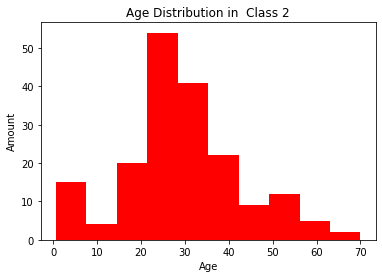

In [603]:
p2=titanic_train_data[titanic_train_data['Pclass']==2]
plt.hist(p2['Age'],color='red')
plt.xlabel('Age')
plt.ylabel('Amount')
plt.title('Age Distribution in  Class 2')


Text(0.5, 1.0, 'Age Distribution in  Class 3')

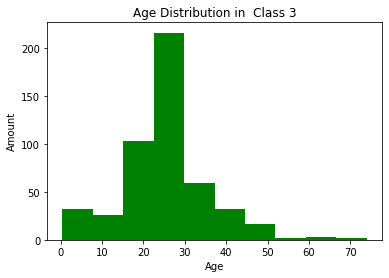

In [604]:
p3=titanic_train_data[titanic_train_data['Pclass']==3]

plt.hist(p3['Age'],color='green')
plt.xlabel('Age')
plt.ylabel('Amount')
plt.title('Age Distribution in  Class 3')


#### Gender Distribution

Let's take a closer look at the gender distribution per passenger class.

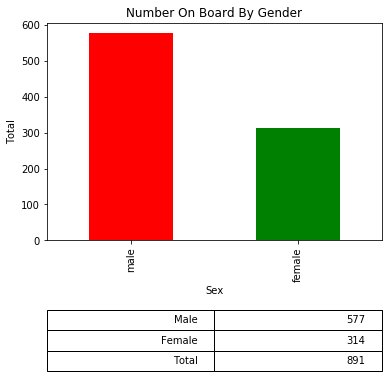

In [605]:
plt.figure
sex_values=titanic_train_data['Sex'].value_counts().sort_index(ascending=False)
sex_values_table=[['Male', len(titanic_train_data[titanic_train_data['Sex'] == 'male'])],  [ 'Female',len(titanic_train_data[titanic_train_data['Sex'] == 'female'])]
                 ,['Total', len(titanic_train_data['Sex'])]]
sex_values.plot('bar',color=color1)
plt.ylabel("Total")
plt.xlabel('Sex')
plt.title('Number On Board By Gender')
plt.table(cellText=sex_values_table, loc='bottom', bbox=[0.0,-0.6,1,.28])

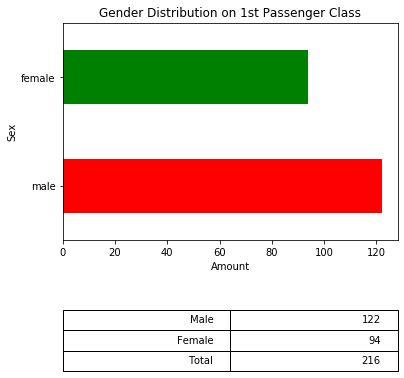

In [606]:
sex_p1=p1['Sex'].value_counts().sort_index(ascending=False)
sex_p1_values_table=[['Male', len(p1[p1['Sex'] == 'male'])],  [ 'Female',len(p1[p1['Sex'] == 'female'])], ['Total', len(p1['Sex'])]]
sex_p1.plot('barh',color=color1)
plt.xlabel('Amount')
plt.ylabel('Sex')
plt.title('Gender Distribution on 1st Passenger Class')
plt.table(cellText=sex_p1_values_table,loc='bottom',bbox=[0,-0.6, 1,0.28])

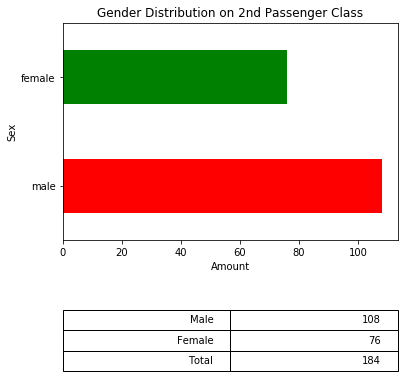

In [607]:
sex_p2=p2['Sex'].value_counts().sort_index(ascending=False)
sex_p2_values_table=[['Male', len(p2[p2['Sex'] == 'male'])],  [ 'Female',len(p2[p2['Sex'] == 'female'])], ['Total', len(p2['Sex'])]]
sex_p2.plot('barh',color=color1)
plt.xlabel('Amount')
plt.ylabel('Sex')
plt.title('Gender Distribution on 2nd Passenger Class')
plt.table(cellText=sex_p2_values_table,loc='bottom',bbox=[0,-0.6, 1,0.28])

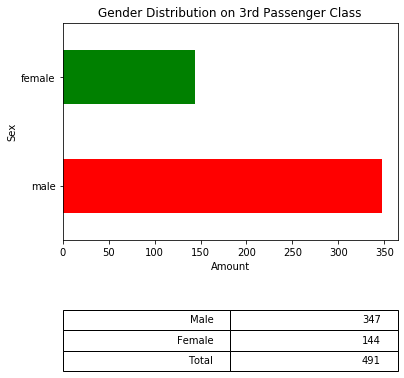

In [608]:
sex_p3=p3['Sex'].value_counts().sort_index(ascending=False)
sex_p3_values_table=[['Male', len(p3[p3['Sex'] == 'male'])],  [ 'Female',len(p3[p3['Sex'] == 'female'])], ['Total',len(p3['Sex']) ]]
sex_p3.plot('barh',color=color1)
plt.xlabel('Amount')
plt.ylabel('Sex')
plt.title('Gender Distribution on 3rd Passenger Class')
plt.table(cellText=sex_p3_values_table,loc='bottom',bbox=[0,-0.6, 1,0.28])

#### Survival on the Titanic

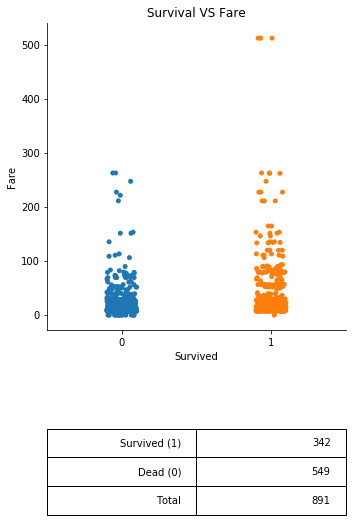

In [609]:
sns.catplot(x='Survived',y= 'Fare', data=titanic_train_data)
survival_fare_table=[['Survived (1)',len(titanic_train_data[titanic_train_data['Survived']==1])],['Dead (0)', len(titanic_train_data[titanic_train_data['Survived']==0])]
                    ,['Total', len(titanic_train_data['Survived'])]]
plt.title('Survival VS Fare')
plt.table(cellText=survival_fare_table, loc='bottom', bbox=[0,-0.6,1,0.28])

I'll take a closer look to find relationships between survival and the other variables in our data.

Let's examine the relationship between Fare price and survival ouput.

In [610]:
#survived_fare_bins=[['Survived',len(titanic_train_data[(titanic_train_data['Survived']==1) & (titanic_train_data['Fare']<50)]), 'Dead',len(titanic_train_data[(titanic_train_data['Survived']==0) & (titanic_train_data['Fare']<50)]), 'Fare: 0 to 50']]
#plt.table(survived_fare_bins,bbox=[0,-0.6,1,0.28] )
fig = go.Figure(data=[go.Table(header=dict(values=['Fare', 'Survived', 'Dead','Total Passengers']),
                 cells=dict(values=[['0-50','50-100' ,'100-200', '200-600'],
                                    [len(titanic_train_data[(titanic_train_data['Survived']==1) & (titanic_train_data['Fare']<=50)])
                                     ,len(titanic_train_data[(titanic_train_data['Survived']==1) & (titanic_train_data['Fare']<=100) & (titanic_train_data['Fare']>50)])
                                     ,len(titanic_train_data[(titanic_train_data['Survived']==1) & (titanic_train_data['Fare']<=200) & (titanic_train_data['Fare']>100)])
                                     ,len(titanic_train_data[(titanic_train_data['Survived']==1) & (titanic_train_data['Fare']<=600) & (titanic_train_data['Fare']>200)])
                                    ],
                                   [
                                     len(titanic_train_data[(titanic_train_data['Survived']==0) & (titanic_train_data['Fare']<=50)]) 
                                    ,len(titanic_train_data[(titanic_train_data['Survived']==0) & (titanic_train_data['Fare']<=100) & (titanic_train_data['Fare']>50)])
                                    ,len(titanic_train_data[(titanic_train_data['Survived']==0) & (titanic_train_data['Fare']<=200) & (titanic_train_data['Fare']>100)])
                                    ,len(titanic_train_data[(titanic_train_data['Survived']==0) & (titanic_train_data['Fare']<=600) & (titanic_train_data['Fare']>200)])
                                   ],
                                    [
                                        233+498
                                        ,70+37
                                        ,25+8
                                        ,14+6
                                    ]
                                    
                     ]))])

data=[fig]
plot(fig)

From our table output, we cannot conclude that fair price influenced chances of survival because we don't have similar number of passengers in each fair price group. For example, we have that 14 out of the 20 passengers who paid a steep price for their ticket survived. On the other hand, for passengers who paid (0-50) only 233 survived out of the 731 passengers. Since more than 80% of the passengers paid (0-50) we can't say for sure fare price influnce chances of survival.

In [611]:
#survived_fare_bins=[['Survived',len(titanic_train_data[(titanic_train_data['Survived']==1) & (titanic_train_data['Fare']<50)]), 'Dead',len(titanic_train_data[(titanic_train_data['Survived']==0) & (titanic_train_data['Fare']<50)]), 'Fare: 0 to 50']]
#plt.table(survived_fare_bins,bbox=[0,-0.6,1,0.28] )
age_fig = go.Figure(data=[go.Table(header=dict(values=['Ages', 'Survived', 'Dead','Total Passengers']),
                 cells=dict(values=[['0-20','20-40','40-60','60-80', '80-100'],
                                    [len(titanic_train_data[(titanic_train_data['Survived']==1) & (titanic_train_data['Age']<=20)])
                                     ,len(titanic_train_data[(titanic_train_data['Survived']==1) & (titanic_train_data['Age']<=40) & (titanic_train_data['Age']>20)])
                                     ,len(titanic_train_data[(titanic_train_data['Survived']==1) & (titanic_train_data['Age']<=60) & (titanic_train_data['Age']>40)])
                                     ,len(titanic_train_data[(titanic_train_data['Survived']==1) & (titanic_train_data['Age']<=80) & (titanic_train_data['Age']>60)])
                                     ,len(titanic_train_data[(titanic_train_data['Survived']==1) & (titanic_train_data['Age']<=100) & (titanic_train_data['Age']>80)])
                                    ],
                                   [
                                     len(titanic_train_data[(titanic_train_data['Survived']==0) & (titanic_train_data['Age']<=20)]) 
                                    ,len(titanic_train_data[(titanic_train_data['Survived']==0) & (titanic_train_data['Age']<=40) & (titanic_train_data['Age']>20)])
                                    ,len(titanic_train_data[(titanic_train_data['Survived']==0) & (titanic_train_data['Age']<=60) & (titanic_train_data['Age']>40)])
                                    ,len(titanic_train_data[(titanic_train_data['Survived']==0) & (titanic_train_data['Age']<=80) & (titanic_train_data['Age']>60)])
                                    ,len(titanic_train_data[(titanic_train_data['Survived']==0) & (titanic_train_data['Age']<=100) & (titanic_train_data['Age']>80)])
                                   ],
                                    [
                                        82+97
                                        ,153+232
                                        ,50+78
                                        ,5+17
                                    ]
                                    
                     ]))])

data=[age_fig]
plot(age_fig)

Again, we don't see a clear indication that age was an influencing factor in survival. All age groups experienced significant losses. And as it is to expect, the larger age groups had more deaths than the smaller age groups.


In [612]:
p1.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,216.000000,216.0,216.000000,216.000000,216.000000,216.000000
mean,0.629630,1.0,36.812130,0.416667,0.356481,84.154687
std,0.484026,0.0,14.182103,0.611898,0.693997,78.380373
min,0.000000,1.0,0.920000,0.000000,0.000000,0.000000
25%,0.000000,1.0,28.000000,0.000000,0.000000,30.923950
50%,1.000000,1.0,35.000000,0.000000,0.000000,60.287500
75%,1.000000,1.0,47.250000,1.000000,0.000000,93.500000
max,1.000000,1.0,80.000000,3.000000,4.000000,512.329200


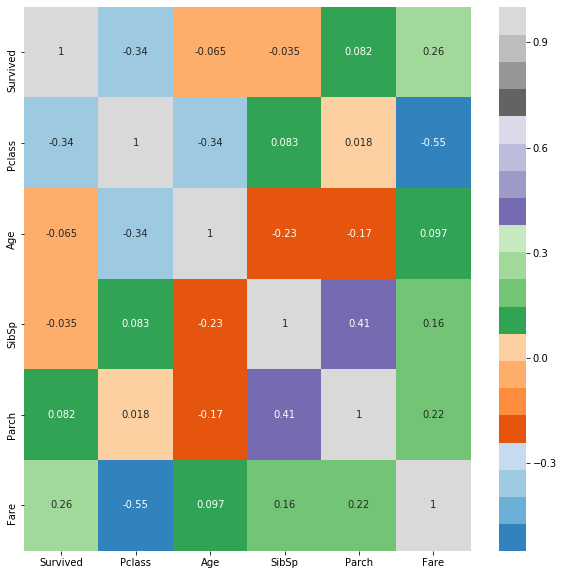

In [613]:
plt.figure(figsize = (10,10))
sns.heatmap(titanic_train_data.corr(),annot = True,cmap="tab20c")
plt.show()

There don't seem to be clear correalations to the chance of survival with the features we are provided.

## Classification Methods

Let's now implement machine learning methods to determine if we can create a model that predicts survival outcome.

In [614]:
titanic_train_data=pd.get_dummies(titanic_train_data,columns=["Sex"])


### K-Means

In [615]:
titanic_test_df=pd.read_csv('test.csv')
titanic_test_df['Age'] = titanic_test_df['Age'].replace(np.nan,titanic_test_df.Age.median())
titanic_test_df['Fare'] = titanic_test_df['Fare'].replace(np.nan,titanic_test_df.Fare.median())
titanic_test_df=titanic_test_df.drop(['Name','Cabin','Embarked','Ticket'], axis=1)
titanic_test_df=pd.get_dummies(titanic_test_df,columns=["Sex"])



In [616]:
#lets create a model bases on our training data

X_train = titanic_train_data.drop(['Survived'], axis=1)
Y_train = titanic_train_data["Survived"]
X_test  = titanic_test_df.drop(["PassengerId"], axis=1)

In [617]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_train)  
knn_accuracy_train = accuracy_score(Y_train,knn_predict_train)
print('accuracy_score on train dataset : ', knn_accuracy_train)

accuracy_score on train dataset :  0.8496071829405163


Our model correctly classified 85% of our training data. It is not the highest, but can provide to us a good approximation 

In [618]:
# predictions on train data
knn_predict_train = knn.predict(X_train)
knn_predict_train

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,

In [619]:
# predict the target on the test dataset
knn_predict_test = knn.predict(X_test)
print('Target on test data\n\n', knn_predict_test)

Target on test data

 [0 0 1 1 0 0 0 1 0 1 1 0 1 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 0 0 1 1 1 0 1 0 0
 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 1 0 0 1 0 0 1 0
 1 1 1 0 0 0 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 1 1 0 1
 1 1 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 1 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 1 0
 1 1 1 1 0 1 0 0 0 1 0 1 1 1 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1
 0 1 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 0
 0 0 0 0 0 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 1 1 0 1 1 0 1 0 1 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 1 1 0 0 1 1 0 0
 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 1 1 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 1
 0 1 0 1 0 1 1 0 0 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 0
 0 1 0 1 1 1 1 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 1 1 0 1 0 0
 1 1 1 1 1 1 1 1 0 1 0]


In [620]:
#Add column of our prediction of survival for each passenger on the test dataset
### Again, the label of 1 means survided, and 0 represents fatalities.
titanic_test_df['knn_predict_survival']=knn_predict_test
titanic_test_df

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,knn_predict_survival
0,892,3,34.5,0,0,7.8292,0,1,0
1,893,3,47.0,1,0,7.0000,1,0,0
2,894,2,62.0,0,0,9.6875,0,1,1
3,895,3,27.0,0,0,8.6625,0,1,1
4,896,3,22.0,1,1,12.2875,1,0,0
5,897,3,14.0,0,0,9.2250,0,1,0
6,898,3,30.0,0,0,7.6292,1,0,0
7,899,2,26.0,1,1,29.0000,0,1,1
8,900,3,18.0,0,0,7.2292,1,0,0
9,901,3,21.0,2,0,24.1500,0,1,1


#### SVM

In [621]:
svm=SVC()
svm.fit(X_train,Y_train)

C:\Users\mcort\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [622]:
svm_predictions=svm.predict(X_train)
svm_predictions

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,

In [623]:
svm_accuracy_train = accuracy_score(Y_train,predictions)
print('accuracy_score on train dataset : ', svm_accuracy_train)

accuracy_score on train dataset :  0.9057239057239057


Using our training dataset, we've created a model that succesfully identified the survival label of 90 percent of the individuals in the training dataset.

In [624]:
#use working model on test dataset
test_svm_predictions=svm.predict(X_test)
print('Target on test data\n\n', test_svm_predictions)

Target on test data

 [0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1
 0 0 1 0 0 0 1 1 0 0 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 1 0
 1 1 0 0 0 0 1 1 1 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0
 0 1 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 1 0
 0 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 1 0 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 0 0 0 0
 0 1 0 0 1 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 1 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 1 0
 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 1 1 0 0 0
 1 1 1 1 1 1 0 1 0 0 0]


In [625]:
#Add column of our prediction of survival for each passenger on the test dataset
### Again, the label of 1 means survided, and 0 represents fatalities.
titanic_test_df['svm_predict_survival']=test_svm_predictions
titanic_test_df

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,knn_predict_survival,svm_predict_survival
0,892,3,34.5,0,0,7.8292,0,1,0,0
1,893,3,47.0,1,0,7.0000,1,0,0,0
2,894,2,62.0,0,0,9.6875,0,1,1,1
3,895,3,27.0,0,0,8.6625,0,1,1,0
4,896,3,22.0,1,1,12.2875,1,0,0,0
5,897,3,14.0,0,0,9.2250,0,1,0,0
6,898,3,30.0,0,0,7.6292,1,0,0,0
7,899,2,26.0,1,1,29.0000,0,1,1,1
8,900,3,18.0,0,0,7.2292,1,0,0,1
9,901,3,21.0,2,0,24.1500,0,1,1,1


#### Decision Trees

In [626]:
dec_tree = DecisionTreeClassifier()


In [627]:
dec_tree.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [628]:
dec_predictions=dec_tree.predict(X_train)
dec_predictions

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,

In [629]:
dec_tree_accuracy_train = accuracy_score(Y_train,dec_predictions)
print('accuracy_score on train dataset : ', dec_tree_accuracy_train)

accuracy_score on train dataset :  0.9797979797979798


In [630]:
dec_tree_predict_test = dec_tree.predict(X_test)
print('Target on test data\n\n', dec_tree_predict_test)

Target on test data

 [0 0 1 1 1 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0
 0 0 1 0 1 0 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 0
 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 1 0 1 0 1 0 0 1 1 0 0
 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0
 1 0 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 1
 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 1 0 0 1 0 1 0 1 0
 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 1 1 1 1 1 1 0 0 0 1 0 1 0 1 0 0 0 0 1 1 0 1
 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0
 1 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 1
 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 0
 0 1 0 0 1 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 0]


In [631]:
#Add column of our prediction of survival for each passenger on the test dataset
### Again, the label of 1 means survided, and 0 represents fatalities.

titanic_test_df['dec_tree_survival_prediction']=dec_tree_predict_test
titanic_test_df.head(10)

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,knn_predict_survival,svm_predict_survival,dec_tree_survival_prediction
0,892,3,34.5,0,0,7.8292,0,1,0,0,0
1,893,3,47.0,1,0,7.0000,1,0,0,0,0
2,894,2,62.0,0,0,9.6875,0,1,1,1,1
3,895,3,27.0,0,0,8.6625,0,1,1,0,1
4,896,3,22.0,1,1,12.2875,1,0,0,0,1
5,897,3,14.0,0,0,9.2250,0,1,0,0,0
6,898,3,30.0,0,0,7.6292,1,0,0,0,0
7,899,2,26.0,1,1,29.0000,0,1,1,1,0
8,900,3,18.0,0,0,7.2292,1,0,0,1,1
9,901,3,21.0,2,0,24.1500,0,1,1,1,0


In [640]:
knn_submission = pd.DataFrame({
        "PassengerId": titanic_test_df["PassengerId"],
        "Survived": knn_predict_test
    })
knn_submission


knn_submission.to_csv('titanic_knn_submission.csv', index=False)

In [641]:
svm_submission = pd.DataFrame({
        "PassengerId": titanic_test_df["PassengerId"],
        "Survived": test_svm_predictions
    })
svm_submission

svm_submission.to_csv('titanic_svm_submission.csv', index=False)

In [642]:
dec_tree_submission = pd.DataFrame({
        "PassengerId": titanic_test_df["PassengerId"],
        "Survived": dec_tree_predict_test
    })
dec_tree_submission

dec_tree_submission.to_csv('titanic_dec_tree_submission.csv', index=False)